In [1]:
import numpy as np
import pandas as pd 
import os
import glob
import time
import sys

In [2]:
# Read data from multiple CSV files into a single pandas dataframe, 
# skip files that contain "trips" and have a corresponding "passages" file
# (we just want each "beep" by the toll, not the start and end destinations)
t1=time.time()
all_files = sorted(glob.glob("/kaggle/input/nsw-toll-road-data/*.csv"))
COLS = ['Date','IntervalStart','TotalVolume','GantryDirection','VehicleClass','AssetID','GantryLocation','GantryGPSLatitude','GantryGPSLongitude']
DTYPES = {
    'TotalVolume': 'uint32',
    'GantryDirection': 'category',
    'VehicleClass': 'category',
    'AssetID': 'category',
    'GantryLocation': 'category',
    'GantryGPSLatitude': 'float32',
    'GantryGPSLongitude': 'float32',
}
li = []

for filename in all_files:
    # print(filename)
    
    # Check if the file name contains "trips" and if there exists a 
    # corresponding file with "passages" in the same folder. If this is the 
    #case, skip the file and moves to the next one.
    fname = filename.split('_')
    if (fname[1]=='trips') and (fname[0]+'_passages_'+fname[2] in all_files):
        # print("Skipping", filename)
        pass

    else:
        try:
            df = pd.read_csv(filename, index_col=None, header=0, usecols=COLS, dtype=DTYPES, engine='pyarrow')
            df['Date_IntervalStart'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['IntervalStart'].astype(str))
            df = df.drop(columns=['Date','IntervalStart'])
            li.append(df)
        except:
            print("Failed", filename)
    
df = pd.concat(li, axis=0, ignore_index=True)

t2=time.time()
print("Time to Load:", t2-t1)

Failed /kaggle/input/nsw-toll-road-data/M5_trips_adt.csv
Failed /kaggle/input/nsw-toll-road-data/M5_trips_awdt.csv
Failed /kaggle/input/nsw-toll-road-data/M5_trips_hourly.csv
Failed /kaggle/input/nsw-toll-road-data/M5_trips_monthly.csv


/tmp/ipykernel_36/1491569643.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(li, axis=0, ignore_index=True)


Time to Load: 297.6186685562134


In [3]:
print(f"{sys.getsizeof(df)/1024**3:,.1f} GB, Rows:{df.shape[0]}, Columns: {df.shape[1]}")

17.2 GB, Rows:81394417, Columns: 8


In [4]:
print(f"That is {df['TotalVolume'].sum():,} total beeps on most of Sydney's Toll roads since 2009")
print(f"Let's plot all the {df.shape[0]:,} rows of data. Quite a few different ways to plot this....")

That is 5,092,966,483 total beeps on most of Sydney's Toll roads since 2009
Let's plot all the 81,394,417 rows of data. Quite a few different ways to plot this....


In [5]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

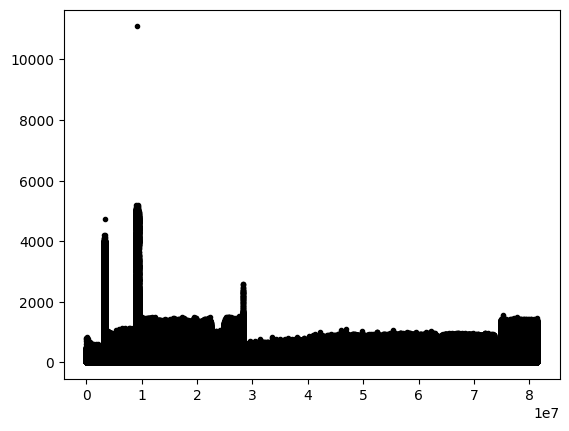

In [6]:
#Start with a simple time vs volume plot. 
plt.plot(df["TotalVolume"],'k.')

{'CCT': 833, 'ED': 4746, 'LCT': 1143, 'M2': 11094, 'M4': 1501, 'M5': 1536, 'M5E': 1071, 'M7': 2591, 'NCX': 561, 'WCX': 1555}
['M2', 'ED', 'M7', 'WCX', 'M5', 'M4', 'LCT', 'M5E', 'CCT', 'NCX']


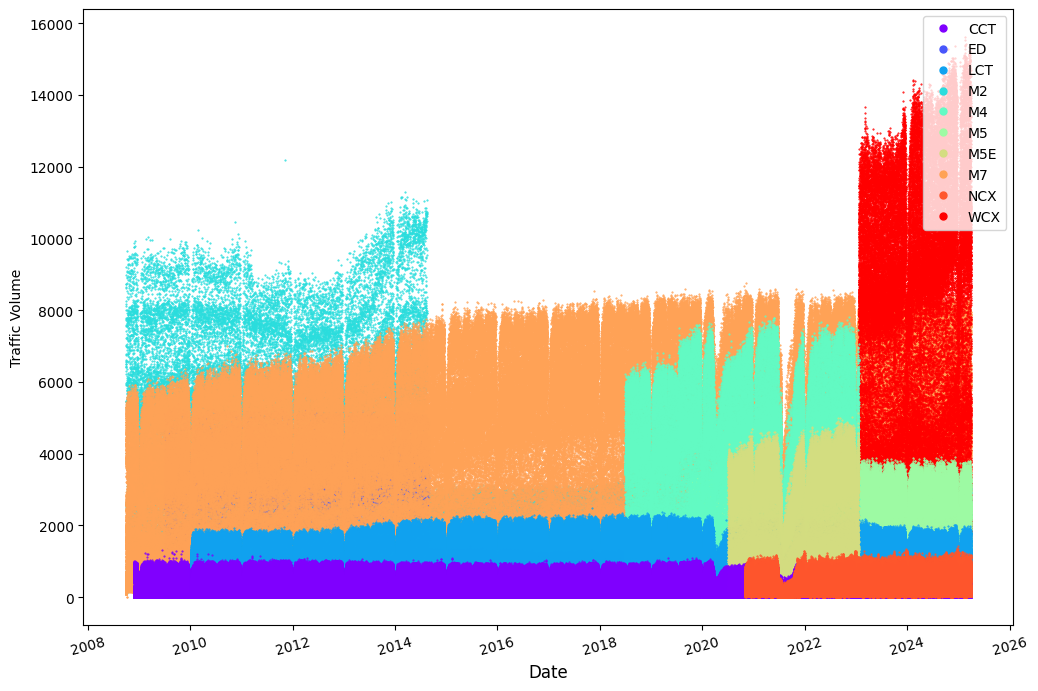

In [7]:
# Let's group by the different Toll roads.
# Then plot the volume.
# But make further groups of the "date" as there are many tolls on a single toll road.
# Use the sum method to combine those groups into a single value for each time and road.
tolls = df.groupby('AssetID')

fig = plt.figure(figsize=(12,8)) 
ax = fig.add_subplot(1,1,1)

maxlist={}
for name,group in tolls:
    maxlist[name]=group.groupby('Date_IntervalStart')["TotalVolume"].max().max()

print(maxlist)
maxlist=sorted(maxlist,key=maxlist.get,reverse=True)
print(maxlist)
    
color = iter(cm.rainbow(np.linspace(0, 1, tolls.ngroups)))
for name,group in tolls:
    c = next(color)
    z=maxlist.index(name) #low number in background
    ax.plot(group.groupby('Date_IntervalStart')["TotalVolume"].sum(),
         color=c, marker='.',markersize=1,linewidth=0.0,label=name,zorder=z)

plt.xlabel('Date',fontsize=12)
plt.ylabel('Traffic Volume')
plt.xticks(rotation=15)
plt.legend(loc='upper right',markerscale=10.)

plt.show()

In [8]:
# Grab a background image of Sydney's Roads
!wget -O Sydney.png https://github.com/natbutter/SydneyTolls/blob/master/Sydney.png?raw=true

--2025-08-15 00:13:26--  https://github.com/natbutter/SydneyTolls/blob/master/Sydney.png?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/natbutter/SydneyTolls/raw/refs/heads/master/Sydney.png [following]
--2025-08-15 00:13:27--  https://github.com/natbutter/SydneyTolls/raw/refs/heads/master/Sydney.png
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/natbutter/SydneyTolls/refs/heads/master/Sydney.png [following]
--2025-08-15 00:13:27--  https://raw.githubusercontent.com/natbutter/SydneyTolls/refs/heads/master/Sydney.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected

In [9]:
# Treat each year seperately
YEARS = [str(year) for year in range(2024, 2007, -1)]
# YEARS = ["2022"]
for YEAR in YEARS:
    # Group the year
    dt1 = pd.to_datetime(YEAR+'-01-01 00:00:00')
    dt2 = pd.to_datetime(str(int(YEAR)+1)+'-01-01 00:00:00')
    dfshort=df[(df.Date_IntervalStart>dt1) & (df.Date_IntervalStart<dt2)]
    # Now group by the unique gantry names across ALL toll roads
    gants = dfshort.groupby('GantryLocation')
    # Pull out the Volu, Lat, Lon for each point.
    gantvol = gants["TotalVolume"].sum().values
    gantlats = gants["GantryGPSLatitude"].mean().values
    gantlngs = gants["GantryGPSLongitude"].mean().values
    
    #############
    #And plot it
    fig=plt.figure(figsize=(16,10)) 
    ax = plt.subplot(111)
    plt.title("Sydney Toll Road Gantry Use for "+YEAR,fontsize=24)

    #Set up the base map, coordinates are from the orignal image output from
    #Mobile Atlas Creator .png and .map oziexplore format
    img_extent = (150.732422,151.347313,-34.015957,-33.651208)
    fname="Sydney.png"
    img = plt.imread(fname)
    plt.imshow(img, origin='upper', extent=img_extent,zorder=0)
 
    #Plot the toll points. Min and max discovered by trial and error.
    tolls=plt.scatter(gantlngs,gantlats,c=gantvol,s=80,
                      cmap='inferno_r',edgecolors=None,vmin=1000000,vmax=10000000)

    #Add all other figure stuff
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    sfmt=ticker.ScalarFormatter(useMathText=True) 
    sfmt.set_powerlimits((6,6))
    cbar=plt.colorbar(tolls, cax=cax,ticks=[1000000, 3000000, 8000000,10000000],format=sfmt)
    cbar.set_label('Number of Beeps',fontsize=20)
    plt.clim(1000000,10000000)

    #Clean up the default axis ticks
    ax.set_xticks([150.8,151.3])
    ax.set_yticks([-34.0,-33.7])

    #Put labels on the figure
    ax.set_xlabel('Longitude',fontsize=20)
    ax.set_ylabel('Latitude',fontsize=20)

    print("Saving",YEAR)
    plt.savefig(YEAR+".png")
    plt.close(fig)

Saving 2024
Saving 2023
Saving 2022
Saving 2021
Saving 2020
Saving 2019
Saving 2018
Saving 2017
Saving 2016
Saving 2015
Saving 2014
Saving 2013
Saving 2012
Saving 2011
Saving 2010
Saving 2009
Saving 2008


In [10]:
#Make a gif animation of the images
from PIL import Image

# Grab all the png files
png_files = sorted(glob.glob("20??.png"))  

print(png_files)
# Load images
images = [Image.open(png) for png in png_files]

# Add a start and end buffer to the animation 
images.insert(0, images[0].copy())
for _ in range(5):
    images.append(images[-1].copy())

# Save as GIF
gif_path = "SydneyTolls_timelapse.gif"
images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=True, duration=500, loop=0, disposal=2)


['2008.png', '2009.png', '2010.png', '2011.png', '2012.png', '2013.png', '2014.png', '2015.png', '2016.png', '2017.png', '2018.png', '2019.png', '2020.png', '2021.png', '2022.png', '2023.png', '2024.png']


![SegmentLocal](SydneyTolls_timelapse.gif "segment")